In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

DIR = '../data'

In [51]:
# Reading names
words = list(set(open(f'{DIR}/names.txt').read().splitlines()))
words[:5]

['cleciera', 'karisa', 'kasdana', 'cirund', 'ruchet']

In [52]:
symbols = sorted(list(set(''.join(words))))
num_of_symbols = 1 + len(symbols)   # adding '.' to the vocab
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [53]:
stoi = {ch: i + 1 for i, ch in enumerate(symbols)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'y', 0: '.'}


### Building dataset
_block_size_: context length (how many previous characters are considered in the prediction) 

_X_: neural net inputs 

_Y_: neural net input labels

In [54]:
block_size = 8
X, Y = [], []

In [55]:
def train_test_split(X: torch.tensor, Y: torch.tensor, p: float):
    train_size = int(p * X.shape[0])

    idxs = set([i for i in range(X.shape[0])])
    train_idxs = set(sample(idxs, k=train_size))
    test_idxs = idxs - train_idxs

    train_idxs, test_idxs = list(train_idxs), list(test_idxs)
    return X[train_idxs], Y[train_idxs], X[test_idxs], Y[test_idxs]

In [56]:
for name in words:
    context = [0] * block_size
    for ch in name + '.':
        idx = stoi[ch]
        X.append(context)
        Y.append(idx)

        # context update
        context = context[1:] + [idx] 

X, Y = torch.tensor(X), torch.tensor(Y)

In [57]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.8)

/tmp/ipykernel_1314/1926032739.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_idxs = set(sample(idxs, k=train_size))


### Layer Classes 

In [58]:
def add_to_class(Class): 
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [59]:
class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self) -> list:
        return [self.weights] + ([] if self.bias is None else [self.bias])

In [60]:
class BatchNorm1d:
    def __init__(self, dim: int, eps: float=1e-5, momentum: float=.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def parameters(self) -> list:
        return [self.gamma, self.beta]

In [61]:
@add_to_class(BatchNorm1d)
def __call__(self, x: torch.tensor) -> torch.tensor:
    if self.training:
        x_mean = x.mean(0, keepdims=True)
        x_var = x.var(0, keepdims=True)
    else:
        x_mean = self.running_mean
        x_var = self.running_var
    
    x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
    self.out = self.gamma * x_hat + self.beta

    if self.training:
        with torch.no_grad():
            self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_var = (1-self.momentum) * self.running_var + self.momentum * x_var
        
    return self.out

In [62]:
class Tanh:
    def __call__(self, x: torch.tensor) -> None:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list:
        return []

In [63]:
class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out

    def parameters(self) -> list:
        return [self.weight]

In [64]:
class Flatten:
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self) -> list:
        return []

In [65]:
class Sequential:
    def __init__(self, layers: list) -> None:
        self.layers = layers
    
    def __call__(self, x: torch.tensor) -> torch.tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

### Parameters and Model Configuration

In [66]:
# Hyperparameters
emb_dimensions = 10
num_of_neurons = 100 

minibatch_size = 32
num_of_epochs = 200000

In [67]:
## NN parameters
hl_input_length = block_size * emb_dimensions
model = Sequential([
    Embedding(num_of_symbols, emb_dimensions),
    Flatten(),
    Linear(hl_input_length, num_of_neurons, bias=False), BatchNorm1d(num_of_neurons), Tanh(),
    Linear(num_of_neurons, num_of_symbols, bias=False)
])

with torch.no_grad():
    model.layers[-1].weights *= .1

In [68]:
parameters = model.parameters()
for p in parameters:
  p.requires_grad = True

### Model Training

In [69]:
losses = []

In [70]:
for i in range(num_of_epochs):
    idx = torch.randint(0, X_train.shape[0], (minibatch_size,))
    X_batch, Y_batch = X_train[idx], Y_train[idx]

    """ Forward pass """
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)                        

    """ Backward pass """
    for p in parameters:
        p.grad = None
    loss.backward()

    """ Update """
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    """ Tracking Stats """
    if not i % 9999 :
        print(f"epoch {i}/{num_of_epochs}: {loss.item():.4f}")
    losses.append(loss.log10().item())

epoch 0/200000: 3.1932
epoch 9999/200000: 1.6568
epoch 19998/200000: 1.8384
epoch 29997/200000: 1.6718
epoch 39996/200000: 1.6955
epoch 49995/200000: 1.9508
epoch 59994/200000: 1.5880
epoch 69993/200000: 1.9290
epoch 79992/200000: 1.3562
epoch 89991/200000: 2.0804
epoch 99990/200000: 1.4929
epoch 109989/200000: 1.1227
epoch 119988/200000: 1.2726
epoch 129987/200000: 1.5235
epoch 139986/200000: 1.4176
epoch 149985/200000: 1.7937
epoch 159984/200000: 1.5555
epoch 169983/200000: 1.6570
epoch 179982/200000: 1.6846
epoch 189981/200000: 1.2640
epoch 199980/200000: 1.5838


### Loss curve

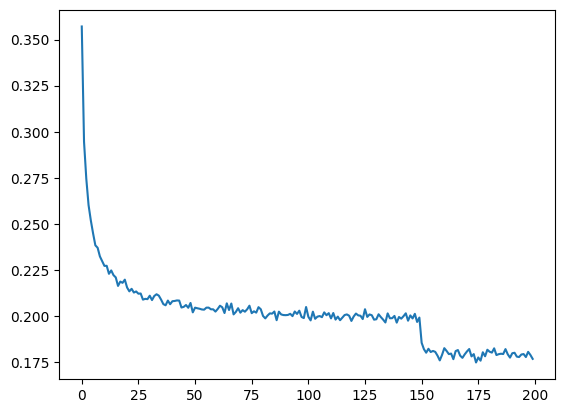

In [71]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [72]:
@torch.no_grad() 
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'test': (X_test, Y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits , y)
    print(split, loss.item())

# Eval mode 
for layer in model.layers:
    layer.training = False

split_loss('train')
split_loss('test')

train 1.4892511367797852
test 1.5163060426712036


### Sampling from the model

In [73]:
samples = []
for _ in range(10):
    idx, out = 0, ""
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [idx]
        if idx == 0:
            break

        out += itos[idx]
    samples.append(out)

print(samples)

['din', 'brontanie', 'sertia', 'yranmind', 'gathean', 'selund', 'irialys', 'fearen', 'emonder', 'ulenela']
